- dataset: **PASCAL VOC 12**
- Metrics: **Precision**, **Recall**, **mean Average Precision**
- Models: **Tow-stage detector** Faster R-CNN, **Single-stage detector** YOLO
- Optimaizers: **Adam**, **AdaGrad**, **RmsProp**

# **Object Detection with PASCAL VOC 12**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import VOCDetection
import xml.etree.ElementTree as ET
from collections import Counter
import cv2
from PIL import Image, ImageDraw

import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from tqdm import tqdm

from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection.ssd import SSD300_VGG16_Weights

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights

from torch.utils.tensorboard import SummaryWriter
import time
import json
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
OUT_DIR = '/content/drive/MyDrive/DL-projet/results/object_detection'
os.makedirs(OUT_DIR, exist_ok=True)

## **Data preprocessing and exploration**

In [4]:
# Define paths and constants
DATA_ROOT = '/content/drive/MyDrive/DL-projet/Data'
BATCH_SIZE = 16
NUM_WORKERS = 4


# VOC class names
VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

### **Define transformations**

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### **Load VOC dataset**

In [6]:
# Custom collate function for batching
def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return images, targets

In [7]:
def load_voc_dataset():
    dir_save = './data'
    try:
        # Create datasets
        train_dataset = VOCDetection(
            root=dir_save,
            year='2012',
            image_set='train',
            download=True,
            transform=train_transform
        )

        val_dataset = VOCDetection(
            root=dir_save,
            year='2012',
            image_set='val',
            download=True,
            transform=val_transform
        )

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            collate_fn=collate_fn,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            collate_fn=collate_fn,
            pin_memory=True
        )

        return train_dataset, val_dataset, train_loader, val_loader

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None, None, None

In [8]:
print("Loading PASCAL VOC 2012 dataset...")
train_dataset, val_dataset, train_loader, val_loader = load_voc_dataset()

Loading PASCAL VOC 2012 dataset...


100%|██████████| 2.00G/2.00G [02:15<00:00, 14.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
if train_dataset is None:
    print("Failed to load dataset. Please check your installation.")

else:
    print("Dataset loaded successfully!")
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")


Dataset loaded successfully!
Number of training samples: 5717
Number of validation samples: 5823


### **Data exploration**

#### Analyze dataset class distribution

In [ ]:
def analyze_class_distribution(dataset):
    class_counts = Counter()

    for _, target in dataset:
        for obj in target['annotation']['object']:
            class_name = obj['name']
            class_counts[class_name] += 1

    # Plot class distribution
    plt.figure(figsize=(14, 7))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution in PASCAL VOC 2012')
    plt.ylabel('Number of Instances')
    plt.tight_layout()
    plt.savefig(OUT_DIR + '/class_distribution_PASCAL_VOC.png')
    plt.show()
    plt.close()

    return class_counts


Analyzing class distribution...


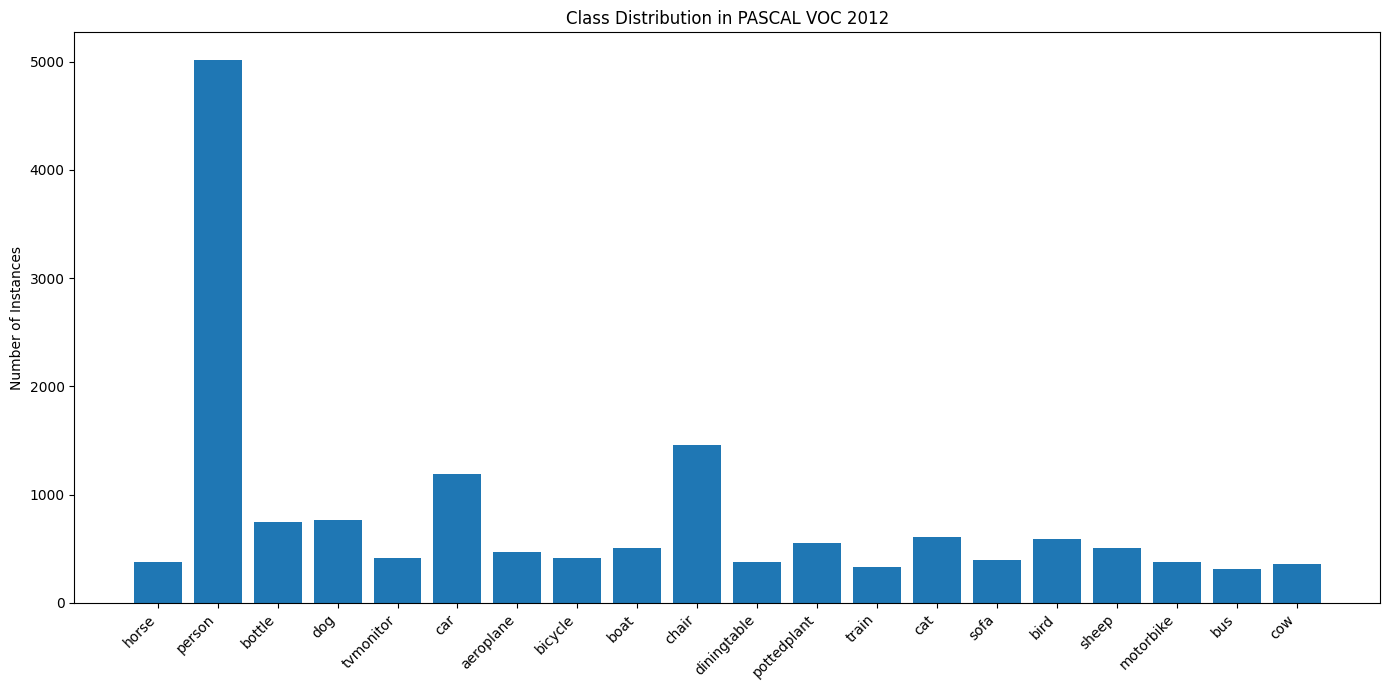

Class distribution: Counter({'person': 5019, 'chair': 1457, 'car': 1191, 'dog': 768, 'bottle': 749, 'cat': 609, 'bird': 592, 'pottedplant': 557, 'sheep': 509, 'boat': 508, 'aeroplane': 470, 'tvmonitor': 412, 'bicycle': 410, 'sofa': 399, 'horse': 377, 'motorbike': 375, 'diningtable': 373, 'cow': 355, 'train': 327, 'bus': 317})


In [ ]:
print("\nAnalyzing class distribution...")
class_counts = analyze_class_distribution(train_dataset)
print(f"Class distribution: {class_counts}")

#### Analyze image sizes

In [ ]:
def analyze_image_sizes(dataset):
    widths = []
    heights = []

    for _, target in dataset:
        size = target['annotation']['size']
        widths.append(int(size['width']))
        heights.append(int(size['height']))

    # Plot image size distribution
    plt.figure(figsize=(14, 7))
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Image Size Distribution in PASCAL VOC 2012')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.grid(True)
    plt.savefig(OUT_DIR + '/image_size_distribution_PASCAL_VOC.png')
    plt.show()
    plt.close()

    return widths, heights


Analyzing image sizes...


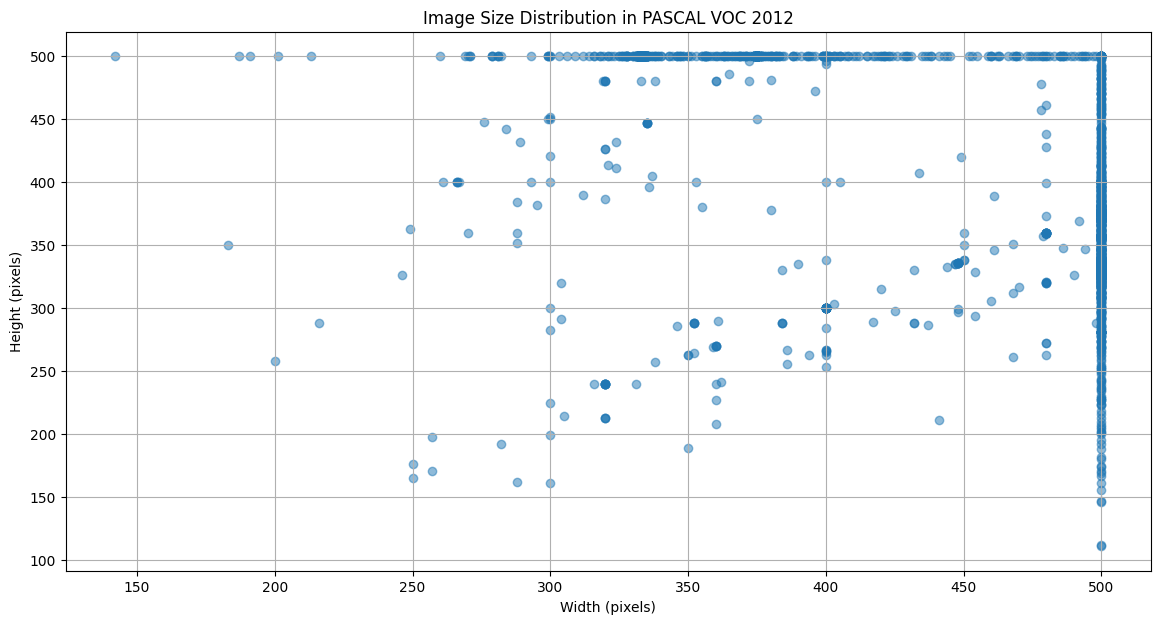

Average image width: 471.68 pixels
Average image height: 385.27 pixels
Min image size: 142x111
Max image size: 500x500


In [ ]:
print("\nAnalyzing image sizes...")
widths, heights = analyze_image_sizes(train_dataset)
print(f"Average image width: {sum(widths) / len(widths):.2f} pixels")
print(f"Average image height: {sum(heights) / len(heights):.2f} pixels")
print(f"Min image size: {min(widths)}x{min(heights)}")
print(f"Max image size: {max(widths)}x{max(heights)}")

#### Visualize sample images with bounding boxes


In [ ]:
def visualize_samples(dataset, num_samples=5):
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img, target = dataset[idx]

        # Convert normalized tensor back to PIL Image
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))

        # Draw bounding boxes
        draw = ImageDraw.Draw(img_pil)

        # Get original image size
        orig_width = int(target['annotation']['size']['width'])
        orig_height = int(target['annotation']['size']['height'])

        # Scale factor for bounding boxes
        scale_x = 512 / orig_width
        scale_y = 512 / orig_height

        for obj in target['annotation']['object']:
            bbox = obj['bndbox']
            xmin = float(bbox['xmin']) * scale_x
            ymin = float(bbox['ymin']) * scale_y
            xmax = float(bbox['xmax']) * scale_x
            ymax = float(bbox['ymax']) * scale_y

            label = obj['name']

            # Draw rectangle
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

            # Draw label
            draw.text((xmin, ymin - 10), label, fill="red")

        # Save the image
        img_pil.save(OUT_DIR + f'/sample_{i+1}.png')

        # Plot the image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_pil)
        plt.axis('off')
        plt.show()

In [ ]:
print("\nVisualizing sample images...")
visualize_samples(train_dataset)

Output hidden; open in https://colab.research.google.com to view.

## **Implementation of Models**

In [10]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Model 1: Faster R-CNN (Two-stage detector)

In [11]:
class FasterRCNNModel:
    def __init__(self, num_classes=21):  # 20 classes + background
        self.num_classes = num_classes
        self.model = self._create_model()
        self.model.to(device)

    def _create_model(self):
        # Load pre-trained Faster R-CNN model
        model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

        # Freeze all parameters in the base model
        for param in model.parameters():
            param.requires_grad = False

        # Replace the classifier with a new one for our number of classes
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)

        # Make sure the box predictor parameters are trainable
        for param in model.roi_heads.box_predictor.parameters():
            param.requires_grad = True

        return model

    def get_model(self):
        return self.model

### Model 2: SSD (Single-stage detector)

In [12]:
class SSDModel:
    def __init__(self, num_classes=21):  # 20 classes + background
        self.num_classes = num_classes
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._create_model()
        self.model.to(self.device)

    def _create_model(self):
        size = 512
        # Load the Torchvision pretrained model.
        model = torchvision.models.detection.ssd300_vgg16(
            weights=SSD300_VGG16_Weights.COCO_V1
        )
        # Retrieve the list of input channels.
        in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
        # List containing number of anchors based on aspect ratios.
        num_anchors = model.anchor_generator.num_anchors_per_location()
        # The classification head.
        model.head.classification_head = SSDClassificationHead(
            in_channels=in_channels,
            num_anchors=num_anchors,
            num_classes=self.num_classes,
        )
        # Image size for transforms.
        model.transform.min_size = (size,)
        model.transform.max_size = size

        for param in model.parameters():
            param.requires_grad = False


        for param in model.head.classification_head.module_list[5].parameters():
            param.requires_grad = True


        for param in model.head.regression_head.module_list[5].parameters():
            param.requires_grad = True

        return model

    def get_model(self):
        return self.model

    def load_checkpoint(self, checkpoint_path):
        """
        Load model from a checkpoint
        """
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        return checkpoint

    def save_model(self, path):
        """
        Save the trained model
        """
        torch.save({
            'model_state_dict': self.model.state_dict(),
        }, path)

In [ ]:
model_class = SSDModel()
model = model_class.get_model()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_EPOCHS = 10
plt.style.use('ggplot')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()

     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        # Move data to device
        images = [img.to(device) for img in images]

        targets = convert_voc_targets(targets)
        targets = [{k: v.to(DEVICE) for k, v in target.items()} for target in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()



        losses.backward()
        optimizer.step()

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
        break
    return loss_value



model = model.to(DEVICE)
print(model)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, nesterov=True)



# To store training loss and mAP values.
train_loss_list = []
map_50_list = []
map_list = []



# Training loop.
for epoch in range(1):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")


    # Start timer and carry out training and validation.

    train_loss = train(train_loader, model)



SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

  0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loss: 43.0293:   0%|          | 0/358 [00:04<?, ?it/s]


In [ ]:
# Initialize model

model.to(device)

# Create optimizer
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)


# Lists to store metrics
epoch_losses = []
grad_stats_history = []

# Training loop
model.train()
for epoch in range(2):
    print(f"Epoch {epoch+1}/{2}")

    running_loss = 0.0
    epoch_grad_stats = []

    # Set model to training mode
    model.train()

    # Iterate over batches
    for images, targets in tqdm(train_loader, desc=f"Training SSD"):
        # Move data to device
        images = [img.to(device) for img in images]

        # Convert VOC annotations to the format required by models
        targets = convert_voc_targets(targets)
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)


        # Calculate total loss
        loss = sum(loss for loss in loss_dict.values())

        # Backward pass
        loss.backward()



        # Update weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item()


print("Training completed!")

Epoch 1/2


Training SSD:  16%|█▌        | 58/358 [00:38<03:19,  1.50it/s]
Exception in thread Thread-14 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 59, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/pin_memory.py", line 35, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/multiprocessing/reductions.py", line 541, in rebuild_storage_fd
    fd = df.detach()
         ^^^

KeyboardInterrupt: 

### Model 2: YOLO (Single-stage detector)

In [ ]:
class YOLOModel:
    def __init__(self, num_classes=21):
        self.num_classes = num_classes
        self.model = self._create_model()
        self.model.to(device)

    def _create_model(self):
        # For simplicity, we'll use an existing implementation from PyTorch Hub
        model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

        # Configure the model for our number of classes
        model.nc = self.num_classes

        # First freeze all parameters
        for param in model.parameters():
            param.requires_grad = False

        # Then selectively unfreeze the detection head parameters
        # The detection heads are in the last layers of the model
        detection_layers = ['model.24', 'model.25']  # Detection heads in YOLOv5s

        for name, param in model.named_parameters():
            if any(layer in name for layer in detection_layers):
                param.requires_grad = True
                print(f"Unfreezing: {name}")  # Debug print to verify

        # Verify we have trainable parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters: {trainable_params}")

        if trainable_params == 0:
            raise ValueError("No trainable parameters found! Check layer names.")

        return model

    def get_model(self):
        return self.model

In [ ]:
class YOLOWrapper(nn.Module):
    def __init__(self, yolo_model):
        super(YOLOWrapper, self).__init__()
        self.model = yolo_model

    def forward(self, images, targets=None):
        # Convert images to the format expected by YOLOv5
        # YOLOv5 expects a list of numpy arrays or a single numpy array
        if isinstance(images, torch.Tensor):
            # Convert batch tensor to list of numpy arrays
            numpy_images = [img.cpu().numpy().transpose(1, 2, 0) for img in images]  # CHW -> HWC
        else:
            # If already a list, convert each tensor to numpy
            numpy_images = [img.cpu().numpy().transpose(1, 2, 0) if isinstance(img, torch.Tensor) else img for img in images]

        if self.training and targets is not None:
            # Convert targets to YOLOv5 format
            yolo_targets = self._convert_targets(targets)
            # YOLOv5 training mode
            results = self.model(numpy_images, yolo_targets)
            return results
        else:
            # For inference
            results = self.model(numpy_images)
            return self._convert_results(results)

    def _convert_targets(self, targets):
        # Convert from our format to YOLOv5 format
        # This needs to match exactly what YOLOv5 expects
        converted_targets = []

        for target in targets:
            boxes = target['boxes']
            labels = target['labels']

            # Get image dimensions (assuming square images of 512x512 as in your code)
            img_size = 512

            # Convert boxes from [x1, y1, x2, y2] to [x_center, y_center, width, height]
            x_center = (boxes[:, 0] + boxes[:, 2]) / 2 / img_size
            y_center = (boxes[:, 1] + boxes[:, 3]) / 2 / img_size
            width = (boxes[:, 2] - boxes[:, 0]) / img_size
            height = (boxes[:, 3] - boxes[:, 1]) / img_size

            # Stack into YOLOv5 format: [class, x_center, y_center, width, height]
            # YOLOv5 expects class to be the first column
            yolo_target = torch.zeros((len(labels), 5))
            yolo_target[:, 0] = labels.float()
            yolo_target[:, 1] = x_center
            yolo_target[:, 2] = y_center
            yolo_target[:, 3] = width
            yolo_target[:, 4] = height

            converted_targets.append(yolo_target)

        return converted_targets

    def _convert_results(self, results):
        # Convert from YOLOv5 results to our format
        detections = []

        # Handle different result formats from YOLOv5
        if hasattr(results, 'xyxy'):
            # If using the Detections class from YOLOv5
            for result in results.xyxy:
                if len(result) > 0:
                    boxes = result[:, :4]  # x1, y1, x2, y2
                    scores = result[:, 4]  # confidence scores
                    labels = result[:, 5].int()  # class labels
                else:
                    boxes = torch.zeros((0, 4))
                    scores = torch.zeros(0)
                    labels = torch.zeros(0, dtype=torch.int64)

                detection = {
                    'boxes': boxes,
                    'scores': scores,
                    'labels': labels
                }
                detections.append(detection)
        else:
            # If results is a list of tensors or a Pandas DataFrame
            for result in results:
                if hasattr(result, 'pandas'):
                    # If result is a YOLOv5 Results object
                    df = result.pandas().xyxy[0]
                    boxes = torch.tensor(df[['xmin', 'ymin', 'xmax', 'ymax']].values)
                    scores = torch.tensor(df['confidence'].values)
                    labels = torch.tensor(df['class'].values, dtype=torch.int64)
                else:
                    # Assuming result is already a tensor with detection info
                    boxes = result[:, :4] if len(result) > 0 else torch.zeros((0, 4))
                    scores = result[:, 4] if len(result) > 0 else torch.zeros(0)
                    labels = result[:, 5].int() if len(result) > 0 else torch.zeros(0, dtype=torch.int64)

                detection = {
                    'boxes': boxes,
                    'scores': scores,
                    'labels': labels
                }
                detections.append(detection)

        return detections

In [13]:
# Function to create optimizer
def create_optimizer(model, name='adam', lr=0.001):
    params = [p for p in model.parameters() if p.requires_grad]

    if name.lower() == 'adam':
        return optim.Adam(params, lr=lr)
    elif name.lower() == 'adagrad':
        return optim.Adagrad(params, lr=lr)
    elif name.lower() == 'rmsprop':
        return optim.RMSprop(params, lr=lr)
    else:
        raise ValueError(f"Optimizer {name} not supported")

In [14]:
# Function to create model and optimizer
def create_model_and_optimizer(model_name, optimizer_name, lr=0.001):
    if model_name.lower() == 'faster_rcnn':
        model_class = FasterRCNNModel()
        model = model_class.get_model()
    elif model_name.lower() == 'yolo':
        model_class = YOLOModel()
        model = YOLOWrapper(model_class.get_model())
    elif model_name.lower() == 'ssd':
        model_class = SSDModel()
        model = model_class.get_model()
    else:
        raise ValueError(f"Model {model_name} not supported")

    optimizer = create_optimizer(model, optimizer_name, lr)
    return model, optimizer

In [15]:
# Function to convert VOC annotations to the format required by models
def convert_voc_targets(targets):
    result = []

    for target in targets:
        # Parse VOC annotations
        boxes = []
        labels = []

        for obj in target['annotation']['object']:
            # Get bounding box
            bbox = obj['bndbox']
            xmin = float(bbox['xmin'])
            ymin = float(bbox['ymin'])
            xmax = float(bbox['xmax'])
            ymax = float(bbox['ymax'])

            # Get class label
            class_name = obj['name']
            class_idx = VOC_CLASSES.index(class_name)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(class_idx)

        # Convert to tensor
        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        result.append({
            'boxes': boxes_tensor,
            'labels': labels_tensor
        })

    return result

## **Experimentation**

### Constants

In [16]:
# Constants
NUM_EPOCHS = 10
LEARNING_RATES = {
    'adam': 0.001,
    'adagrad': 0.01,
    'rmsprop': 0.001
}
CHECKPOINT_DIR = OUT_DIR + '/checkpoints'
LOG_DIR = OUT_DIR + '/logs'
RESULTS_DIR = OUT_DIR + '/results'


# Create directories if they don't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [17]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Function to calculate gradient statistics

In [18]:
# Function to calculate gradient statistics
def calculate_gradient_stats(model):
    grad_stats = {}
    total_norm = 0

    for name, param in model.named_parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
            grad_stats[name] = {
                'mean': param.grad.data.mean().item(),
                'std': param.grad.data.std().item(),
                'min': param.grad.data.min().item(),
                'max': param.grad.data.max().item(),
                'norm': param_norm.item()
            }

    total_norm = total_norm ** 0.5
    grad_stats['total_norm'] = total_norm

    return grad_stats

### Function to visualize gradients

In [19]:
# Function to visualize gradients
def visualize_gradients(grad_stats_history, model_name, optimizer_name, output_dir=OUT_DIR + '/gradient_plots'):
    os.makedirs(output_dir, exist_ok=True)

    # Plot total gradient norm over time
    plt.figure(figsize=(10, 6))
    plt.plot([stats['total_norm'] for stats in grad_stats_history])
    plt.title(f'Total Gradient Norm Over Time ({model_name} - {optimizer_name})')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Norm')
    plt.grid(True)
    plt.savefig(f'{output_dir}/{model_name}_{optimizer_name}_total_norm.png')
    plt.show()
    plt.close()

    # Get a few key layers to visualize (first layer, middle layer, last layer)
    all_layers = list(grad_stats_history[0].keys())
    all_layers.remove('total_norm')  # Remove total norm from the list

    if len(all_layers) > 3:
        selected_layers = [all_layers[0], all_layers[len(all_layers)//2], all_layers[-1]]
    else:
        selected_layers = all_layers

    # Plot mean gradient magnitude for selected layers
    plt.figure(figsize=(12, 6))
    for layer in selected_layers:
        if not layer.startswith('_'):  # Skip internal layers
            plt.plot([stats[layer]['mean'] for stats in grad_stats_history], label=f'{layer} (mean)')
    plt.title(f'Mean Gradient Magnitude for Selected Layers ({model_name} - {optimizer_name})')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Mean')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{output_dir}/{model_name}_{optimizer_name}_mean_gradients.png')
    plt.show()
    plt.close()

    # Plot standard deviation of gradients for selected layers
    plt.figure(figsize=(12, 6))
    for layer in selected_layers:
        if not layer.startswith('_'):  # Skip internal layers
            plt.plot([stats[layer]['std'] for stats in grad_stats_history], label=f'{layer} (std)')
    plt.title(f'Gradient Standard Deviation for Selected Layers ({model_name} - {optimizer_name})')
    plt.xlabel('Iteration')
    plt.ylabel('Gradient Std')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{output_dir}/{model_name}_{optimizer_name}_std_gradients.png')
    plt.show()
    plt.close()


### Training function

In [20]:
# Training function with checkpointing
def train_model(model, train_loader, optimizer, model_name, optimizer_name, num_epochs=NUM_EPOCHS, start_epoch=0):
    # Check if we have a previously created TensorBoard log for this experiment
    log_path = f'{LOG_DIR}/{model_name}_{optimizer_name}'

    # If continuing from a checkpoint, use existing log directory
    if start_epoch > 0:
        existing_logs = [d for d in os.listdir(LOG_DIR) if d.startswith(f'{model_name}_{optimizer_name}_')]
        if existing_logs:
            # Use the most recent log directory
            latest_log = sorted(existing_logs)[-1]
            log_path = f'{LOG_DIR}/{latest_log}'
    else:
        # Create new log directory with timestamp
        log_path = f'{LOG_DIR}/{model_name}_{optimizer_name}_{datetime.now().strftime("%Y%m%d-%H%M%S")}'

    # Set up TensorBoard
    writer = SummaryWriter(log_path)

    # Set model to training mode
    model.train()

    # Lists to store metrics - load previous data if continuing
    checkpoint_path = f'{CHECKPOINT_DIR}/progress_{model_name}_{optimizer_name}.pth'

    if start_epoch > 0 and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        epoch_losses = checkpoint.get('epoch_losses', [])
        grad_stats_history = checkpoint.get('grad_stats_history', [])
    else:
        epoch_losses = []
        grad_stats_history = []

    # Training loop
    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        running_loss = 0.0
        epoch_grad_stats = []

        # Iterate over batches
        for images, targets in tqdm(train_loader, desc=f"Training {model_name} with {optimizer_name}"):
            # Move data to device
            images = [img.to(device) for img in images]

            # Convert VOC annotations to the format required by models
            targets = convert_voc_targets(targets)
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            if model_name.lower() == 'faster_rcnn':
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())

            elif model_name.lower() == 'ssd':
                loss_dict = model(images, targets)

                loss = sum(loss for loss in loss_dict.values())
                # loss_value = losses.item()
            else:  # YOLO
                loss = model(images, targets)
                loss = sum(loss.values()) if isinstance(loss, dict) else loss

            # Backward pass
            loss.backward()

            # Calculate gradient statistics before optimizer step
            grad_stats = calculate_gradient_stats(model)
            grad_stats_history.append(grad_stats)

            # Update weights
            optimizer.step()

            # Update running loss
            running_loss += loss.item()

        # Calculate epoch loss
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)


        # Log to TensorBoard
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Grad/total_norm', grad_stats['total_norm'], epoch)


        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

        # Save progress checkpoint (for resuming training)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'epoch_losses': epoch_losses,
            'grad_stats_history': grad_stats_history,
        }, checkpoint_path)

        # Save model checkpoint (separate file per epoch)
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, f'{CHECKPOINT_DIR}/{model_name}_{optimizer_name}_epoch_{epoch+1}.pth')

    # Visualize gradients
    visualize_gradients(grad_stats_history, model_name, optimizer_name)

    # Close TensorBoard writer
    writer.close()

    return model, epoch_losses, grad_stats_history


### Evaluation function

In [21]:
# Calculate IoU (Intersection over Union)
def calculate_iou(box1, box2):
    # Extract coordinates
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Calculate intersection coordinates
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)

    # Calculate areas
    intersection_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou



# Calculate precision and recall for a specific class at a specific IoU threshold
def calculate_precision_recall(predictions, targets, class_id, iou_threshold=0.5, score_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Process each image's predictions and targets
    for pred, target in zip(predictions, targets):
        # Filter predictions by class and score
        pred_boxes = pred['boxes'][pred['labels'] == class_id]
        pred_scores = pred['scores'][pred['labels'] == class_id]
        pred_boxes = pred_boxes[pred_scores >= score_threshold]

        # Filter targets by class
        target_boxes = target['boxes'][target['labels'] == class_id]

        # Mark which targets have been matched
        matched_targets = [False] * len(target_boxes)

        # Match predictions to targets
        for pred_box in pred_boxes:
            best_iou = iou_threshold
            best_target_idx = -1

            for i, target_box in enumerate(target_boxes):
                if not matched_targets[i]:
                    iou = calculate_iou(pred_box, target_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_target_idx = i

            if best_target_idx >= 0:
                # True positive - matched a target
                true_positives += 1
                matched_targets[best_target_idx] = True
            else:
                # False positive - didn't match any target
                false_positives += 1

        # Count unmatched targets as false negatives
        false_negatives += sum(1 for matched in matched_targets if not matched)

    # Calculate precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall



# Calculate Average Precision for a specific class
def calculate_ap(predictions, targets, class_id, iou_threshold=0.5):
    # Get all scores for this class
    all_scores = []
    for pred in predictions:
        mask = pred['labels'] == class_id
        if mask.any():
            all_scores.extend(pred['scores'][mask].tolist())

    if not all_scores:
        return 0.0

    # Sort scores in descending order
    all_scores = sorted(set(all_scores), reverse=True)

    # Calculate precision and recall at different score thresholds
    precisions = []
    recalls = []

    for score_threshold in all_scores:
        precision, recall = calculate_precision_recall(predictions, targets, class_id, iou_threshold, score_threshold)
        precisions.append(precision)
        recalls.append(recall)

    # Add (1.0, 0.0) to both lists to ensure the curve starts at recall=0
    precisions = [1.0] + precisions
    recalls = [0.0] + recalls

    # Calculate AP using 11-point interpolation
    ap = 0.0
    for t in np.arange(0.0, 1.1, 0.1):
        if np.sum(np.array(recalls) >= t) == 0:
            p = 0
        else:
            p = np.max(np.array(precisions)[np.array(recalls) >= t])
        ap += p / 11.0

    return ap

In [22]:
# Calculate metrics: precision, recall, mAP
def calculate_metrics(predictions, targets):
    metrics = {}

    # Calculate metrics for each class
    for class_id in range(1, len(VOC_CLASSES)):  # Skip background class
        # Calculate precision and recall at IoU threshold 0.5
        precision, recall = calculate_precision_recall(predictions, targets, class_id)

        # Calculate Average Precision
        # it take a lot of time
        # ap = calculate_ap(predictions, targets, class_id)

        metrics[VOC_CLASSES[class_id]] = {
            'precision': precision,
            'recall': recall,
            # 'AP': ap
        }

    # Calculate mAP (mean Average Precision)
    # metrics['mAP'] = sum(metrics[VOC_CLASSES[class_id]]['AP'] for class_id in range(1, len(VOC_CLASSES))) / (len(VOC_CLASSES) - 1)

    return metrics

In [23]:
# Evaluation function
def evaluate_model(model, val_loader, model_name):
    # Set model to evaluation mode
    model.eval()

    # Lists to store metrics
    all_predictions = []
    all_targets = []

    # No gradient calculation during evaluation
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Evaluating {model_name}"):
            # Move data to device
            images = [img.to(device) for img in images]

            # Convert VOC annotations to the format required by models
            gt_targets = convert_voc_targets(targets)

            # Forward pass
            outputs = model(images)

            # Store predictions and targets
            all_predictions.extend(outputs)
            all_targets.extend(gt_targets)

    # Calculate metrics
    metrics = calculate_metrics(all_predictions, all_targets)

    return metrics


### Function to visualize results from different optimizers

In [24]:
def visualize_optimizer_comparison(results, output_dir=OUT_DIR + '/optimizer_comparison'):
    os.makedirs(output_dir, exist_ok=True)

    # Plot training loss comparison
    plt.figure(figsize=(12, 6))
    for model_name in results:
        for optimizer_name in results[model_name]:
            plt.plot(results[model_name][optimizer_name]['train_losses'],
                     label=f"{model_name} - {optimizer_name}")

    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{output_dir}/training_loss_comparison.png')
    plt.show()
    plt.close()

    '''# Plot mAP comparison
    plt.figure(figsize=(12, 6))
    models = list(results.keys())
    optimizers = list(results[models[0]].keys())

    x = np.arange(len(models))
    width = 0.25

    for i, optimizer in enumerate(optimizers):
        mean_aps = [results[model][optimizer]['metrics']['mAP'] for model in models]
        plt.bar(x + i*width, mean_aps, width, label=optimizer)

    plt.title('mAP Comparison')
    plt.xlabel('Model')
    plt.ylabel('mAP')
    plt.xticks(x + width, models)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/map_comparison.png')
    plt.show()
    plt.close()'''

    # Plot precision and recall comparison for each model
    for model_name in results:
        plt.figure(figsize=(12, 6))

        for i, optimizer_name in enumerate(results[model_name]):
            precision = [results[model_name][optimizer_name]['metrics'][class_name]['precision']
                         for class_name in VOC_CLASSES[1:]]  # Skip background class
            recall = [results[model_name][optimizer_name]['metrics'][class_name]['recall']
                     for class_name in VOC_CLASSES[1:]]  # Skip background class

            plt.scatter(recall, precision, label=optimizer_name, alpha=0.7)

        plt.title(f'Precision-Recall Comparison ({model_name})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{output_dir}/{model_name}_precision_recall.png')
        plt.show()
        plt.close()

    '''# Plot class-wise AP comparison
    for model_name in results:
        plt.figure(figsize=(15, 8))

        class_names = VOC_CLASSES[1:]  # Skip background class
        x = np.arange(len(class_names))
        width = 0.25

        for i, optimizer_name in enumerate(results[model_name]):
            ap_values = [results[model_name][optimizer_name]['metrics'][class_name]['AP']
                         for class_name in class_names]
            plt.bar(x + i*width, ap_values, width, label=optimizer_name)

        plt.title(f'Class-wise AP Comparison ({model_name})')
        plt.xlabel('Class')
        plt.ylabel('Average Precision')
        plt.xticks(x + width, class_names, rotation=45, ha='right')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{model_name}_class_ap.png')
        plt.show()
        plt.close()'''

### Function to visualize detection results

In [25]:
# Function to visualize detection results
def visualize_detection_results(model, val_loader, model_name, num_samples=5, output_dir=OUT_DIR + '/detection_results'):
    os.makedirs(output_dir, exist_ok=True)

    # Set model to evaluation mode
    model.eval()

    samples_visualized = 0
    with torch.no_grad():
        for images, targets in val_loader:
            if samples_visualized >= num_samples:
                break

            # Move data to device
            images_device = [img.to(device) for img in images]

            # Get predictions
            predictions = model(images_device)

            # Visualize each image in the batch
            for i, (image, target, prediction) in enumerate(zip(images, targets, predictions)):
                if samples_visualized >= num_samples:
                    break

                # Convert normalized tensor back to PIL Image
                img_np = image.permute(1, 2, 0).numpy()
                img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img_np = np.clip(img_np, 0, 1)
                img_np = (img_np * 255).astype(np.uint8)

                # Create a copy for ground truth visualization
                img_gt = img_np.copy()

                # Create a copy for predictions visualization
                img_pred = img_np.copy()

                # Draw ground truth bounding boxes
                for obj in target['annotation']['object']:
                    # Get bounding box
                    bbox = obj['bndbox']
                    xmin = float(bbox['xmin'])
                    ymin = float(bbox['ymin'])
                    xmax = float(bbox['xmax'])
                    ymax = float(bbox['ymax'])

                    # Scale to image size
                    h, w = img_gt.shape[:2]
                    xmin = int(xmin * w / 512)
                    ymin = int(ymin * h / 512)
                    xmax = int(xmax * w / 512)
                    ymax = int(ymax * h / 512)

                    # Draw rectangle
                    cv2.rectangle(img_gt, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

                    # Draw label
                    label = obj['name']
                    cv2.putText(img_gt, label, (xmin, ymin - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

                # Draw predictions
                for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
                    # Only draw high-confidence detections
                    if score > 0.5:
                        # Get coordinates
                        xmin, ymin, xmax, ymax = box.cpu().numpy()

                        # Scale to image size
                        h, w = img_pred.shape[:2]
                        xmin = int(xmin * w / 512)
                        ymin = int(ymin * h / 512)
                        xmax = int(xmax * w / 512)
                        ymax = int(ymax * h / 512)

                        # Get class name
                        class_name = VOC_CLASSES[label]

                        # Draw rectangle
                        cv2.rectangle(img_pred, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

                        # Draw label and score
                        text = f"{class_name}: {score:.2f}"
                        cv2.putText(img_pred, text, (xmin, ymin - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

                # Combine ground truth and predictions side by side
                combined_img = np.hstack((img_gt, img_pred))

                # Save the combined image
                cv2.imwrite(f"{output_dir}/{model_name}_sample_{samples_visualized + 1}.jpg",
                            cv2.cvtColor(combined_img, cv2.COLOR_RGB2BGR))

                samples_visualized += 1


### Main function to run the experiments

In [26]:
# Main function to run the experiments with resume capability
def run_experiments(train_loader, val_loader):
    # Ensure results directory exists
    os.makedirs(RESULTS_DIR, exist_ok=True)

    # Path to experiments progress tracking file
    progress_file = f'{RESULTS_DIR}/experiments_progress.json'

    # Define models and optimizers to experiment with
    models = [ 'ssd']  #'faster_rcnn',
    optimizers = ['adam', 'adagrad', 'rmsprop']

    # Load existing progress if available
    if os.path.exists(progress_file):
        with open(progress_file, 'r') as f:
            try:
                progress = json.load(f)
                results = progress.get('results', {})
                completed = progress.get('completed', [])
            except json.JSONDecodeError:
                # Handle corrupted JSON file
                results = {}
                completed = []
    else:
        results = {}
        completed = []

    # Run experiments for each model and optimizer combination
    for model_name in models:
        if model_name not in results:
            results[model_name] = {}

        for optimizer_name in optimizers:
            # Check if this experiment was already completed
            experiment_id = f"{model_name}_{optimizer_name}"
            if experiment_id in completed:
                print(f"Skipping {experiment_id} - already completed")
                continue

            print(f"\n=============== Running {model_name} with {optimizer_name} ===============\n")

            # Check if we need to resume training
            checkpoint_path = f'{CHECKPOINT_DIR}/progress_{model_name}_{optimizer_name}.pth'
            start_epoch = 0

            if os.path.exists(checkpoint_path):
                checkpoint = torch.load(checkpoint_path)
                start_epoch = checkpoint.get('epoch', 0)
                print(f"Resuming training from epoch {start_epoch}")

            # Create model and optimizer
            model, optimizer = create_model_and_optimizer(model_name, optimizer_name, LEARNING_RATES[optimizer_name])

            # Load model and optimizer state if resuming
            if start_epoch > 0:
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            # Train model
            trained_model, train_losses, grad_stats = train_model(
                model, train_loader, optimizer, model_name, optimizer_name,
                start_epoch=start_epoch
            )

            # Evaluate model
            metrics = evaluate_model(trained_model, val_loader, model_name)

            # Store results
            results[model_name][optimizer_name] = {
                'train_losses': train_losses,
                'metrics': metrics
            }

            # Save detailed results to a separate file
            experiment_results_file = f'{RESULTS_DIR}/{experiment_id}_results.pth'
            torch.save({
                'train_losses': train_losses,
                'grad_stats': grad_stats,
                'metrics': metrics,
                'model_name': model_name,
                'optimizer_name': optimizer_name
            }, experiment_results_file)

            # Mark this experiment as completed
            completed.append(experiment_id)

            # Update progress file after each experiment
            with open(progress_file, 'w') as f:
                json.dump({
                    'results': results,
                    'completed': completed,
                    'last_updated': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                }, f, indent=4)

            # Visualize detection results
            visualize_detection_results(trained_model, val_loader, experiment_id)

    # Visualize comparisons only after all experiments are done
    visualize_optimizer_comparison(results)

    # Save final results
    with open(f'{RESULTS_DIR}/final_results.json', 'w') as f:
        json.dump(results, f, indent=4)

    return results

## **Exicute Training and Evaluation**

In [27]:
models = ['faster_rcnn', 'ssd']
optimizers = ['adam', 'adagrad', 'rmsprop']
for model_name in models:
    for optimizer_name in optimizers:
        print(f"\n=============== Running {model_name} with {optimizer_name} ===============\n")

        # Create model and optimizer
        model, optimizer = create_model_and_optimizer(model_name, optimizer_name, LEARNING_RATES[optimizer_name])

        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total trainable parameters: {total_params:,}")



=============== Running faster_rcnn with adam ===============



Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 138MB/s]


Total trainable parameters: 107,625

=============== Running faster_rcnn with adagrad ===============

Total trainable parameters: 107,625

=============== Running faster_rcnn with rmsprop ===============

Total trainable parameters: 107,625

=============== Running ssd with adam ===============



Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 172MB/s]


Total trainable parameters: 230,500

=============== Running ssd with adagrad ===============

Total trainable parameters: 230,500

=============== Running ssd with rmsprop ===============

Total trainable parameters: 230,500



=============== Running ssd with adam ===============

Epoch 1/10


Training ssd with adam: 100%|██████████| 358/358 [03:37<00:00,  1.64it/s]


Epoch 1 Loss: 42.4295
Epoch 2/10


Training ssd with adam: 100%|██████████| 358/358 [03:31<00:00,  1.70it/s]


Epoch 2 Loss: 42.3953
Epoch 3/10


Training ssd with adam: 100%|██████████| 358/358 [03:31<00:00,  1.70it/s]


Epoch 3 Loss: 42.4252
Epoch 4/10


Training ssd with adam: 100%|██████████| 358/358 [03:30<00:00,  1.70it/s]


Epoch 4 Loss: 42.4642
Epoch 5/10


Training ssd with adam: 100%|██████████| 358/358 [03:31<00:00,  1.70it/s]


Epoch 5 Loss: 42.4003
Epoch 6/10


Training ssd with adam: 100%|██████████| 358/358 [03:31<00:00,  1.69it/s]


Epoch 6 Loss: 42.3241
Epoch 7/10


Training ssd with adam: 100%|██████████| 358/358 [03:30<00:00,  1.70it/s]


Epoch 7 Loss: 42.3481
Epoch 8/10


Training ssd with adam: 100%|██████████| 358/358 [03:32<00:00,  1.69it/s]


Epoch 8 Loss: 42.3648
Epoch 9/10


Training ssd with adam: 100%|██████████| 358/358 [03:30<00:00,  1.70it/s]


Epoch 9 Loss: 42.4772
Epoch 10/10


Training ssd with adam: 100%|██████████| 358/358 [03:29<00:00,  1.71it/s]


Epoch 10 Loss: 42.4212


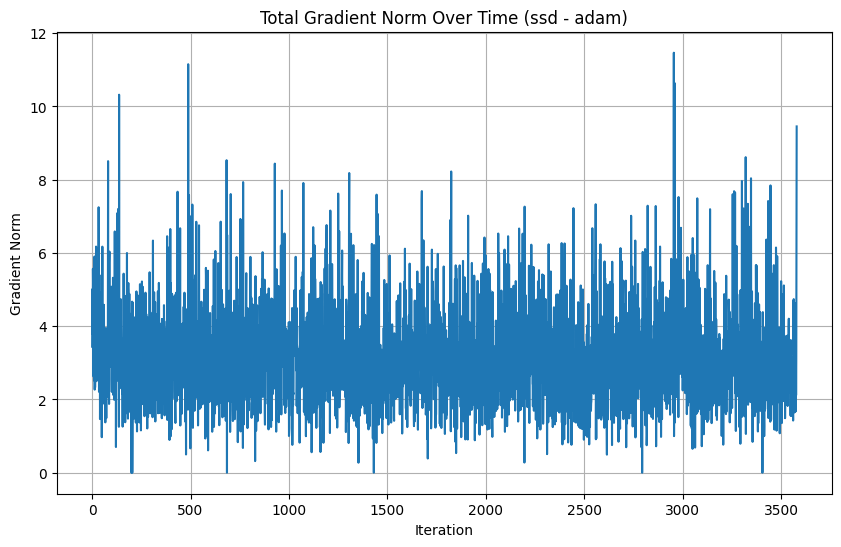

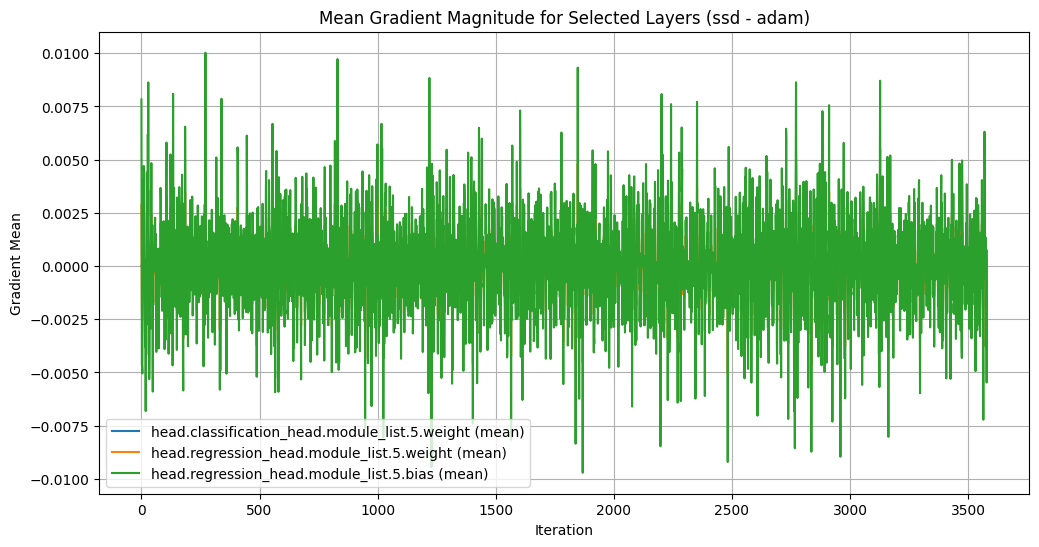

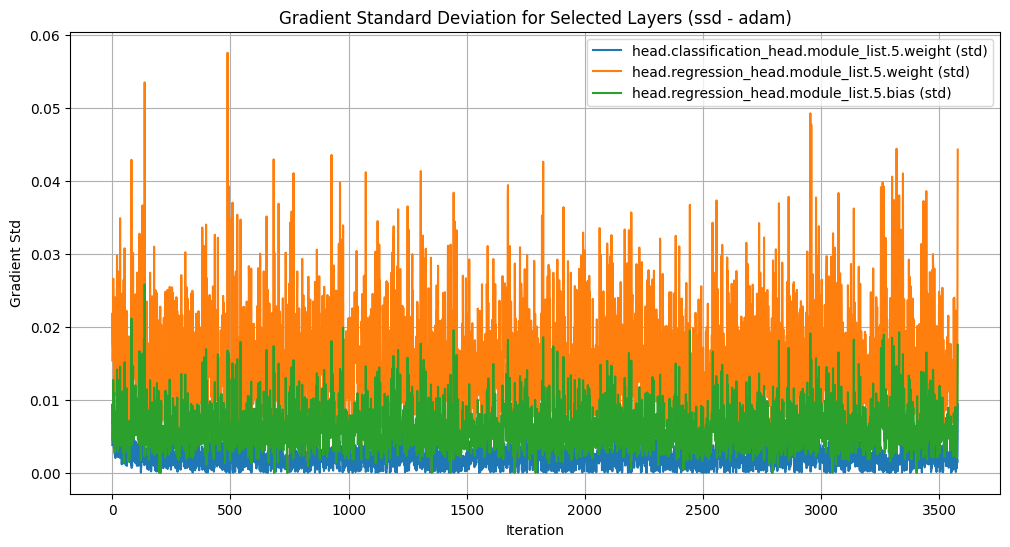

Evaluating ssd: 100%|██████████| 364/364 [03:18<00:00,  1.83it/s]



=============== Running ssd with adagrad ===============

Epoch 1/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:31<00:00,  1.69it/s]


Epoch 1 Loss: 41.8045
Epoch 2/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:32<00:00,  1.69it/s]


Epoch 2 Loss: 41.7289
Epoch 3/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:31<00:00,  1.69it/s]


Epoch 3 Loss: 41.6837
Epoch 4/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:32<00:00,  1.69it/s]


Epoch 4 Loss: 41.6787
Epoch 5/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:34<00:00,  1.67it/s]


Epoch 5 Loss: 41.6655
Epoch 6/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:32<00:00,  1.69it/s]


Epoch 6 Loss: 41.6842
Epoch 7/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:32<00:00,  1.68it/s]


Epoch 7 Loss: 41.6402
Epoch 8/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:31<00:00,  1.69it/s]


Epoch 8 Loss: 41.6174
Epoch 9/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:32<00:00,  1.68it/s]


Epoch 9 Loss: 41.6257
Epoch 10/10


Training ssd with adagrad: 100%|██████████| 358/358 [03:32<00:00,  1.68it/s]


Epoch 10 Loss: 41.6957


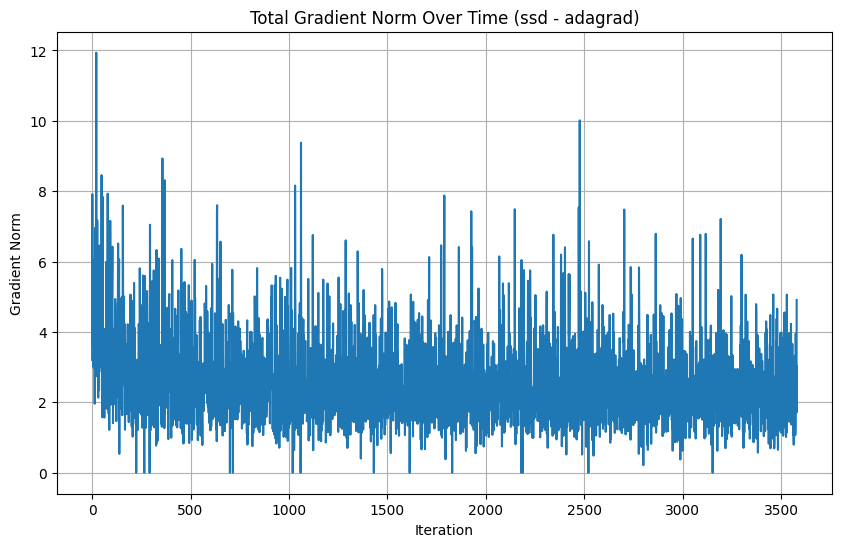

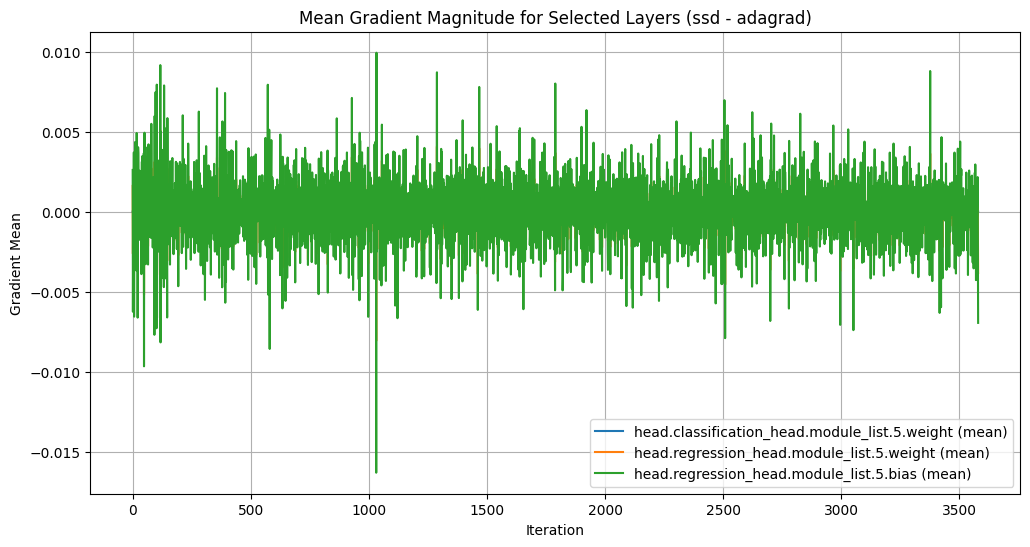

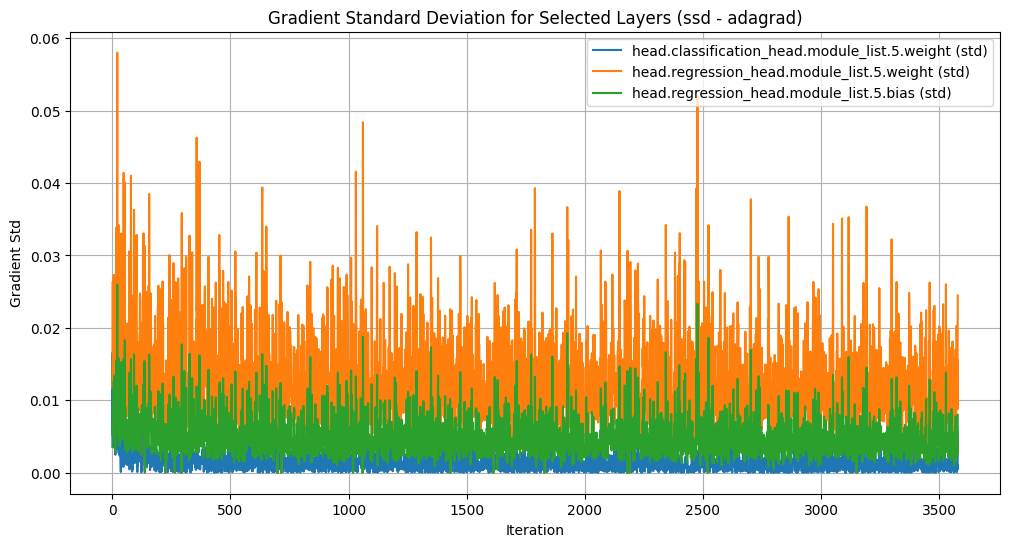

Evaluating ssd: 100%|██████████| 364/364 [03:11<00:00,  1.91it/s]



=============== Running ssd with rmsprop ===============

Epoch 1/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:32<00:00,  1.68it/s]


Epoch 1 Loss: 41.4465
Epoch 2/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:34<00:00,  1.67it/s]


Epoch 2 Loss: 41.3852
Epoch 3/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:34<00:00,  1.67it/s]


Epoch 3 Loss: 41.3249
Epoch 4/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:39<00:00,  1.63it/s]


Epoch 4 Loss: 41.4061
Epoch 5/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:33<00:00,  1.67it/s]


Epoch 5 Loss: 41.4046
Epoch 6/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:35<00:00,  1.66it/s]


Epoch 6 Loss: 41.3456
Epoch 7/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:36<00:00,  1.66it/s]


Epoch 7 Loss: 41.3185
Epoch 8/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:33<00:00,  1.68it/s]


Epoch 8 Loss: 41.3942
Epoch 9/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:34<00:00,  1.67it/s]


Epoch 9 Loss: 41.3462
Epoch 10/10


Training ssd with rmsprop: 100%|██████████| 358/358 [03:32<00:00,  1.68it/s]


Epoch 10 Loss: 41.3852


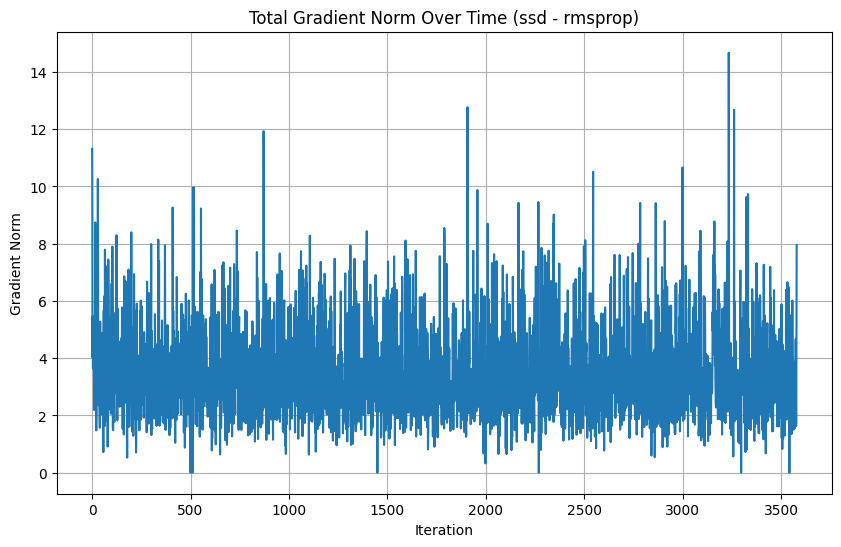

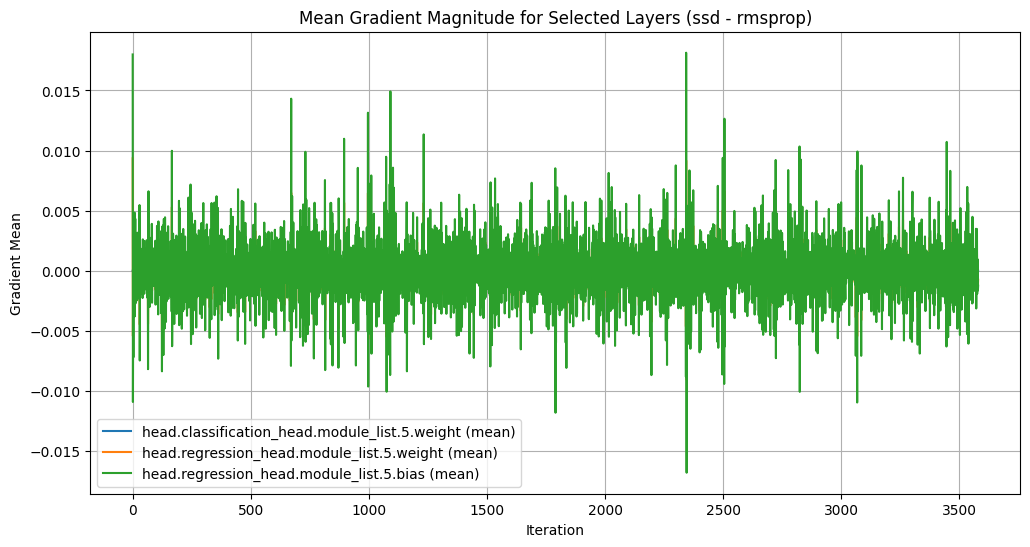

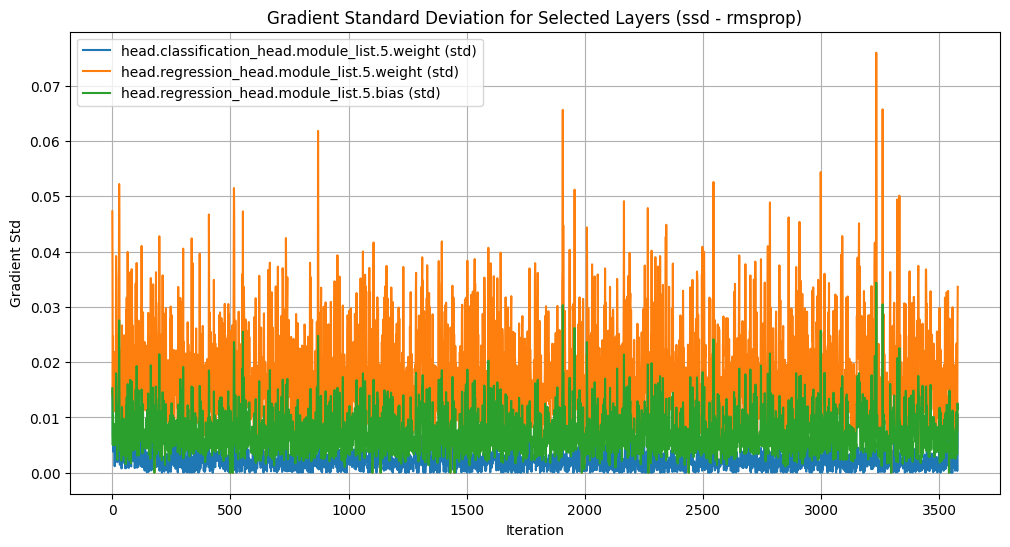

Evaluating ssd: 100%|██████████| 364/364 [03:11<00:00,  1.90it/s]


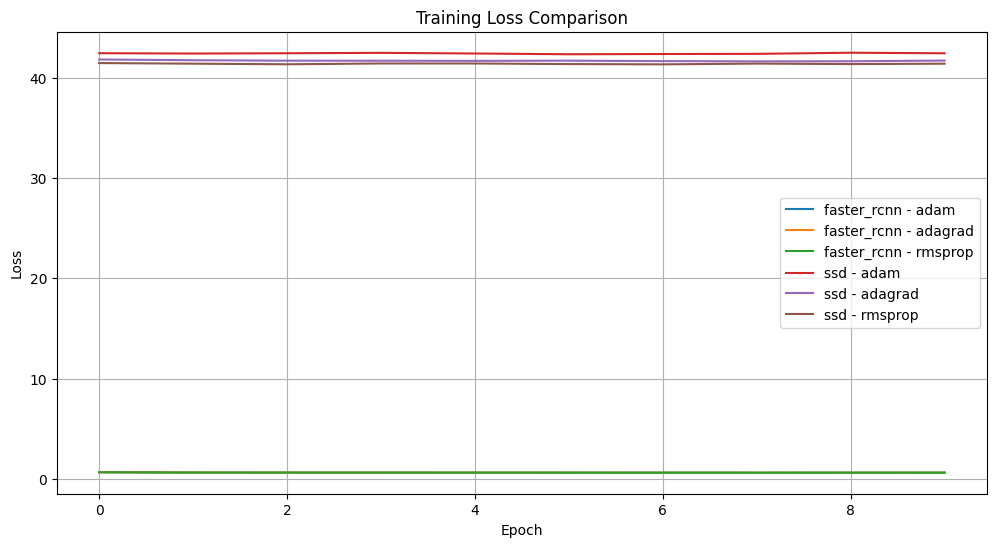

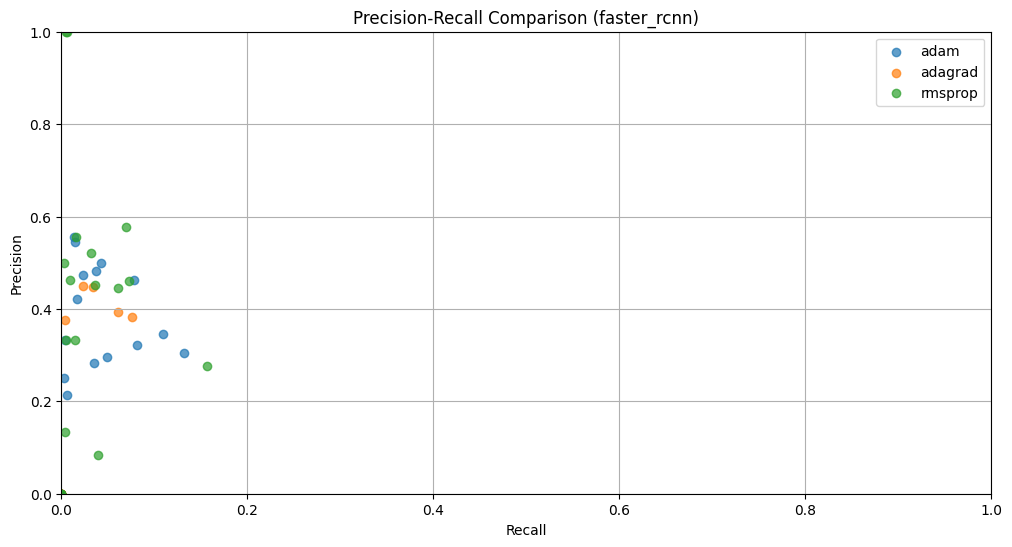

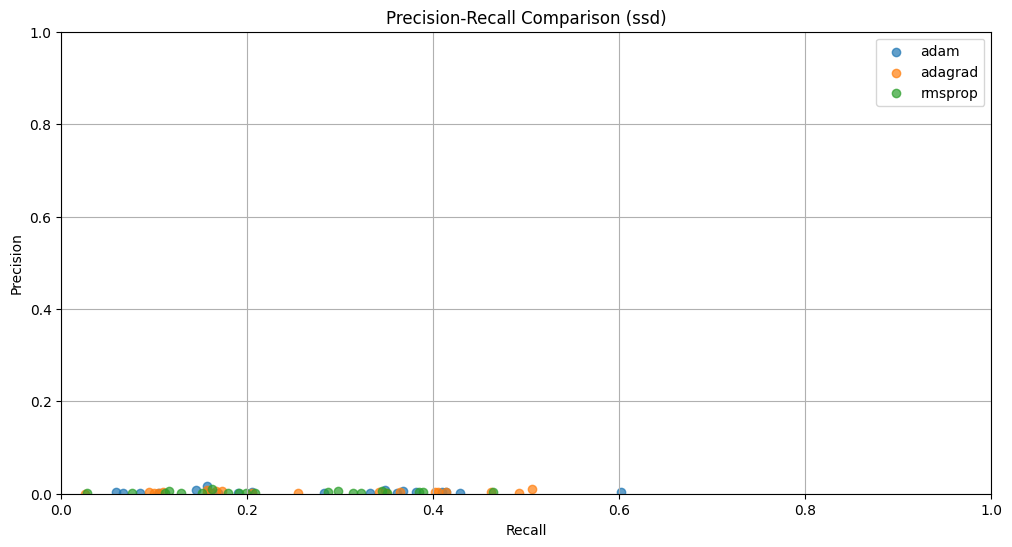

{'faster_rcnn': {'adam': {'train_losses': [0.6915046617638465,
    0.6502317491523381,
    0.6416456554522062,
    0.6417329949040652,
    0.6392179685098499,
    0.6378362439364694,
    0.6377933627233825,
    0.6329966146686223,
    0.6336950191072912,
    0.633486633027732],
   'metrics': {'aeroplane': {'precision': 0.3047619047619048,
     'recall': 0.1322314049586777},
    'bicycle': {'precision': 0.4827586206896552,
     'recall': 0.03684210526315789},
    'bird': {'precision': 0.28205128205128205, 'recall': 0.034976152623211444},
    'boat': {'precision': 0.21428571428571427, 'recall': 0.006109979633401222},
    'bottle': {'precision': 0, 'recall': 0.0},
    'bus': {'precision': 0.32098765432098764, 'recall': 0.08125},
    'car': {'precision': 0.29591836734693877, 'recall': 0.0494458653026428},
    'cat': {'precision': 0.46153846153846156, 'recall': 0.07766990291262135},
    'chair': {'precision': 0.0, 'recall': 0.0},
    'cow': {'precision': 0, 'recall': 0.0},
    'diningtable'

In [28]:
run_experiments(train_loader, val_loader)

In [ ]:
run_experiments(train_loader, val_loader)


=============== Running faster_rcnn with adam ===============

Resuming training from epoch 7
Epoch 8/10


Training faster_rcnn with adam: 100%|██████████| 358/358 [07:02<00:00,  1.18s/it]


Epoch 8 Loss: 0.6330
Epoch 9/10


Training faster_rcnn with adam: 100%|██████████| 358/358 [07:04<00:00,  1.19s/it]


Epoch 9 Loss: 0.6337
Epoch 10/10


Training faster_rcnn with adam: 100%|██████████| 358/358 [07:04<00:00,  1.19s/it]


Epoch 10 Loss: 0.6335


Evaluating faster_rcnn: 100%|██████████| 364/364 [06:55<00:00,  1.14s/it]



=============== Running faster_rcnn with adagrad ===============

Epoch 1/10


Training faster_rcnn with adagrad: 100%|██████████| 358/358 [07:01<00:00,  1.18s/it]


Epoch 1 Loss: 0.6732
Epoch 2/10


Training faster_rcnn with adagrad: 100%|██████████| 358/358 [07:02<00:00,  1.18s/it]


Epoch 2 Loss: 0.6475
Epoch 3/10


Training faster_rcnn with adagrad: 100%|██████████| 358/358 [07:01<00:00,  1.18s/it]


Epoch 3 Loss: 0.6404
Epoch 4/10


Training faster_rcnn with adagrad: 100%|██████████| 358/358 [07:01<00:00,  1.18s/it]


Epoch 4 Loss: 0.6375
Epoch 5/10


Training faster_rcnn with adagrad: 100%|██████████| 358/358 [07:01<00:00,  1.18s/it]


Epoch 5 Loss: 0.6367
Epoch 6/10


Training faster_rcnn with adagrad: 100%|██████████| 358/358 [07:03<00:00,  1.18s/it]


Epoch 6 Loss: 0.6373
Epoch 7/10


Training faster_rcnn with adagrad:  14%|█▍        | 51/358 [01:04<05:48,  1.14s/it]

https://arxiv.org/pdf/2104.11892